## Part 2: metric methods and categorical features

All further experiments are proposed to be conducted on the Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

In this task, it is proposed to predict whether an employee’s request for access to a particular resource will be approved. All signs are categorical.

File: amazon.csv in archive

Immediately read the data and create a partition for learning and control:

In [3]:
import numpy as np
import pandas as pd

In [4]:
data = pd.read_csv('amazon.csv')

In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

#### 1. Implement three distance functions on categorical features.

The easiest way is to define the metrics as [user-defined distance] (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), then use the kNN implementation from sklearn (in this case use function predict_proba).

Try to pay special attention to the effectiveness of the code - when implementing metrics "in the forehead" you may encounter a very long execution time.

#### Count for each of the metrics the quality on the test sample `X_test` with the number of neighbors k = 10. A measure of quality - AUC-ROC.

### What is the best distance function?

In [4]:
X_train_np, y_train_np, X_test_np, y_test_np = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

In [5]:
del X_train, y_train, X_test, y_test, data

In [19]:
f = lambda v: np.argsort(np.apply_along_axis(np.count_nonzero, 1, X_train_np - v))

In [22]:
a = time.time()
d_matrix = np.apply_along_axis(f, 1, X_test_np)
time.time() - a

792.8109059333801

In [70]:
from sklearn.metrics import roc_auc_score
vote = lambda x: get_majority_vote(x, y_train_np)

In [237]:
ans = np.apply_along_axis(vote, 1, d_matrix[:,:10])
roc_auc_score(y_test_np, ans)

0.83088009598014845

In [193]:
l = X_train_np.shape[0]
u = []
for i in range(9): 
    u1 = np.unique(X_train_np[:,i], return_counts=True)
    u1 = list(zip(u1[0], u1[1]/l, np.multiply(u1[1], u1[1]-1)/l/(l-1)))
    u1.sort(key=lambda x: x[1], reverse=False)
    u.append(u1)

In [239]:
def get_sum(value, u, indexes):
    weight = 0
    #for j in indexes:
    j = indexes
    current_p = 1
    c = 0
    while c < len(u[j]) and current_p >= u[j][c][1]:
        weight += u[j][c][2]
        if value == u[j][c][0]:
            current_p = u[j][c][1]
        c+=1
    return (weight)

In [242]:
d = [dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()]
for i in range(9): 
    for value in u[i]:
        d[i][value[0]] = get_sum(value[0], u, i)

In [247]:
d = np.array(d)

In [260]:
def get_metric_2(xv, v):
    indexes = np.where(xv==0)[0]
#     print(indexes)
    dist = len(xv) - len(indexes)
    
    for i in indexes:
        try:
            dist += d[i][v[i]]
        except:
            print(i, v[i])
            raise
    return dist

In [261]:
f2 = lambda v: np.argsort(np.apply_along_axis(get_metric_2, 1, X_train_np - v, v))

In [271]:
a = time.time()
d_matrix_2 = np.apply_along_axis(f2, 1, X_test_np)
time.time() - a

1734.2014150619507

In [326]:
np.savetxt("d_metric3.csv", d_matrix_3, delimiter=",")

In [325]:
ans_metric2 = np.apply_along_axis(vote, 1, d_matrix_2[:,:10])
roc_auc_score(y_test_np, ans_metric2)

0.83423907769345729

In [312]:
l = X_train_np.shape[0]
m = []
for i in range(9): 
    u1 = np.unique(X_train_np[:,i], return_counts=True)
    u1 = dict(zip(u1[0], np.log(u1[1]/l + 1)))
    m.append(u1)

In [314]:
def get_metric_3(xv, v):
    indexes = np.where(xv!=0)[0]
    dist = 0#len(xv) - len(indexes)
    
    for i in indexes:
        try:
            dist += m[i].get(v[i],0)*m[i][xv[i]+v[i]]
        except:
            print(i, v[i], xv[i]+v[i])
            raise
    return dist

In [316]:
f3 = lambda v: np.argsort(np.apply_along_axis(get_metric_3, 1, X_train_np - v, v))

In [320]:
a = time.time()
d_matrix_3 = np.apply_along_axis(f3, 1, X_test_np)
time.time() - a

4017.9494671821594

In [324]:
ans_metric3 = np.apply_along_axis(vote, 1, d_matrix_3[:,:10])
roc_auc_score(y_test_np, ans_metric3)

0.80123107551392003

Answer: 1st metric AUC-ROC = 0.83088009598014845;  2nd: 0.83423907769345729;  3rd: 0.80123107551392003
Best: 2nd one.

#### 2 (bonus). Pick the best (on the test sample) the number of neighbors k for each of the distance functions. What is the best quality possible to get?

For the selection, you can use any means of sklearn.

In [328]:
aucs_1 = []
for K in range(1, 100):
    aucs_1.append(roc_auc_score(y_test_np, np.apply_along_axis(vote, 1, d_matrix[:,:K])))


In [158]:
import matplotlib.pyplot as plt
%matplotlib inline

In [341]:
max(aucs_1)

0.83120195870812086

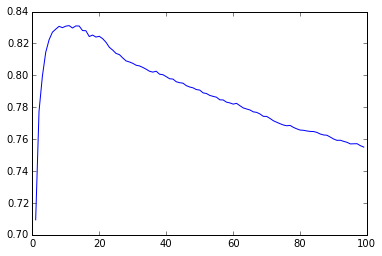

In [336]:
plt.plot(range(1,100), aucs_1)

 k=11 max for the first one

In [339]:
aucs_2 = []
for K in range(1, 100):
    aucs_2.append(roc_auc_score(y_test_np, np.apply_along_axis(vote, 1, d_matrix_2[:,:K])))

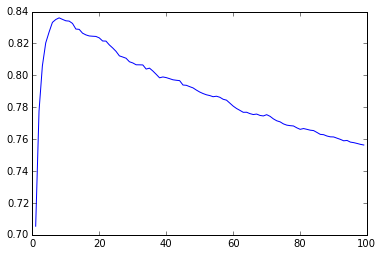

In [340]:
plt.plot(range(1,100), aucs_2)

In [342]:
max(aucs_2)

0.83607114334410881

max for k==8 

In [344]:
aucs_3 = []
for K in range(1, 100):
    aucs_3.append(roc_auc_score(y_test_np, np.apply_along_axis(vote, 1, d_matrix_3[:,:K])))

In [345]:
max(aucs_3)

0.80464064592512075

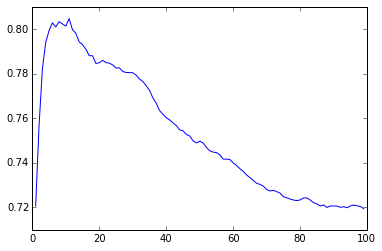

In [346]:
plt.plot(range(1,100), aucs_3)

for k==11 max

#### 3. Implement the counters (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx) that will replace the categorical features on real.

Namely, each categorical attribute must be replaced by three:
1. The number of `counts` of objects in the training set with the same characteristic value.
2. The number of `successes` objects of the first class y = 1 in the training sample with the same attribute value.
3. The smoothed ratio of the two previous values: (`successes` + 1) / (` counts` + 2).

Since attributes containing information about the target variable may lead to retraining, it may be useful to do * folding *: split the training set into n parts, and for the i-th part, consider `counts` and` successes` for all the rest parts. For the test sample, counters are counted for the entire training sample. Implement this option. You can use n = 3.

#### On the AUC-ROC method, test the k closest neighbors with a Euclidean metric for a sample where categorical features are replaced by counters. Compare the AUC-ROC two options for forming the sample - with and without folding. Do not forget to choose the best number of neighbors k.

In [7]:
from sklearn.cross_validation import KFold

In [11]:
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [18]:
data.RESOURCE.value_counts()[data.RESOURCE].values

array([  3,  30,   2, ..., 161,   7, 127])

In [146]:
def counterize(data, test_data, target='ACTION', nf=1):
    alpha = 1.0
    if nf != 1:
        alpha =  float(nf - 1)/(float(nf))
        
    new_data = pd.DataFrame()
    new_test = pd.DataFrame()
    for column in data.columns:
        if column == target:
            continue
        value_counts = data[column].value_counts()
        succecc_counts = data[data[target]==1][column].value_counts()
        
        new_data[column + '_count'] = value_counts[data[column]].values*alpha
        new_data[column + '_succecc'] = succecc_counts[data[column]].values*alpha
        new_data[column + '_p']  = (value_counts[data[column]]*alpha + 1.0).values/(succecc_counts[data[column]]*alpha + 2.0).values
        
        new_test[column + '_count'] = value_counts[test_data[column]].values*alpha
        new_test[column + '_succecc'] = succecc_counts[test_data[column]].values*alpha
        new_test[column + '_p']  = (value_counts[test_data[column]]*alpha + 1.0).values/(succecc_counts[test_data[column]]*alpha + 2.0).values
                
    new_data.index = data.index
    new_test.index = test_data.index
    new_test = new_test.fillna(0)
    new_data = new_data.fillna(0)
    return new_data, new_test

In [147]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

In [148]:
new_train, new_test = counterize(pd.concat([X_train, y_train], axis=1), X_test)

In [149]:
from sklearn.cross_validation import KFold

In [150]:
def counterize_fold(X_train, y_train, X_test, num_folds=3):
    kf = KFold(X_train.shape[0], num_folds)
    new_data = pd.DataFrame()
    new_test = pd.DataFrame()
    new_train_target = pd.Series()
    for train, test in kf:
        kf_train = X_train.iloc[train].copy()
        kf_test = X_train.iloc[test].copy()
        kf_y_train = y_train.iloc[train]
        kf_y_test = y_train.iloc[test]
        
        new_kf_train, new_kf_test = counterize(pd.concat([kf_train, kf_y_train], axis=1), kf_test)
        
        new_data = new_data.append(new_kf_test.copy())
        new_train_target = new_train_target.append(kf_y_test) 
    new_train_all, new_test_all = counterize(pd.concat([X_train, y_train], axis=1), X_test, nf=num_folds)
    
    return new_data, new_train_target, new_test_all

In [151]:
x_t, y_t, x_tst = counterize_fold(X_train, y_train, X_test)

In [152]:
from sklearn.neighbors import KNeighborsClassifier

In [157]:
aucs_counters = []
for K in range(1, 200):
    clf =  KNeighborsClassifier(n_neighbors=K, weights='distance')
    clf.fit(x_t, y_t)
    aucs_counters.append(roc_auc_score(y_test, clf.predict_proba(x_tst)[:,1]))

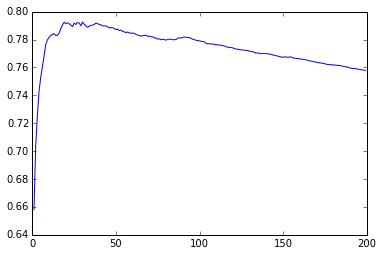

In [159]:
plt.plot(range(1,200), aucs_counters)

In [160]:
aucs_counters_withoutfold = []
for K in range(1, 50):
    clf =  KNeighborsClassifier(n_neighbors=K, weights='distance')
    clf.fit(new_train, y_t)
    aucs_counters_withoutfold.append(roc_auc_score(y_test, clf.predict_proba(new_test)[:,1]))

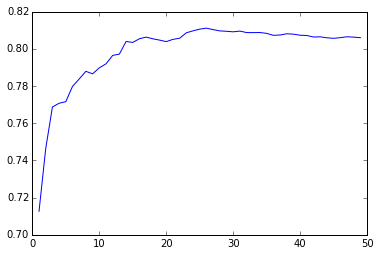

In [161]:
plt.plot(range(1,50), aucs_counters_withoutfold)

without folding is better

#### 4. Add paired signs to the original sample — that is, for each pair f(i), f(j),  i <j  of the original categorical signs, add a new categorical sign f(ij), the value of which is a concatenation of values f(i) and f(j) (preferably through some special character to avoid collisions). Count the counters for this sample, find the quality of the k nearest neighbors method with the best k (with and without folding).

In [162]:
def create_new_columns(data):
    new_data = data.copy()
    all_columns = list(data.columns.values)
    for i in range(len(all_columns)):
        for j in range(i+1, len(all_columns)):
            new_data[all_columns[i] + ";" + all_columns[j]] = (new_data[all_columns[i]].map(str)+  ";" + new_data[all_columns[j]].map(str))
    return new_data


In [163]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)
X_train = create_new_columns(X_train)
X_test = create_new_columns(X_test)

In [165]:
new_train, new_test = counterize(pd.concat([X_train, y_train], axis=1), X_test)

In [166]:
x_t, y_t, x_tst = counterize_fold(X_train, y_train, X_test)

In [167]:
aucs_counters_pairs = []
for K in range(1, 50):
    clf =  KNeighborsClassifier(n_neighbors=K, weights='distance')
    clf.fit(new_train, y_train)
    aucs_counters_pairs.append(roc_auc_score(y_test, clf.predict_proba(new_test)[:,1]))

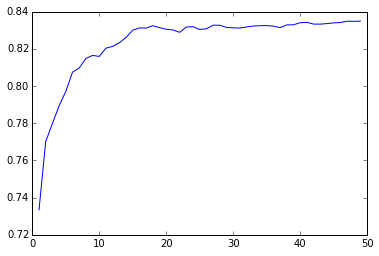

In [168]:
plt.plot(range(1,50), aucs_counters_pairs)

In [169]:
aucs_counters_pairs_fold = []
for K in range(1, 50):
    clf =  KNeighborsClassifier(n_neighbors=K, weights='distance')
    clf.fit(x_t, y_t)
    aucs_counters_pairs_fold.append(roc_auc_score(y_test, clf.predict_proba(x_tst)[:,1]))

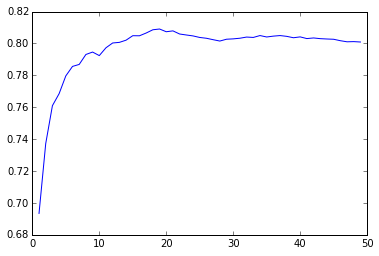

In [174]:
plt.plot(range(1,50), aucs_counters_pairs_fold)

So, this one is much better than with paired features

## Part 3: Decisive trees and forests

#### 1. Take from the previous section a dataset with paired features, converted using counters without folding. Set up the decision tree by selecting the optimal values for the `max_depth` and` min_samples_leaf` parameters. What is the best AUC-ROC ?

In [175]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)
from sklearn.tree import DecisionTreeClassifier
X_train = create_new_columns(X_train)
X_test = create_new_columns(X_test)
X_train, X_test =  counterize(pd.concat([X_train, y_train], axis=1), X_test)


In [193]:
clf =  DecisionTreeClassifier(max_depth=1, min_samples_leaf=5)
clf.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

0.578786011425


#### 2. Set up a random forest, picking up a number of trees `n_estimators`, in which the error goes on the asymptote. What quality on the test sample does it give?

In [196]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
print( roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

0.680726820313
